# Réseaux de neurones 

## Import des modules et des bases de données

In [1]:
import torch as tch
import numpy as np

from toolbox import disp, disp_loss, disp_2losses
from torch.utils.data import Dataset
from torchvision.io import read_image

In [2]:
#device = 'cuda'
device = 'cpu'

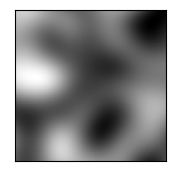

In [3]:
img = read_image('img/gaussian_field.png')[0]
n_y, n_x = img.shape
disp(img);

## Conversion en dataset (X,Y) 

In [4]:

# X : position du pixel
# Y : valeur de pixel
l = tch.arange(0,n_y).to(tch.float32)-n_y//2
l_x, l_y = tch.meshgrid(l,l, indexing='xy')
X = tch.concat((l_x.reshape((1,n_y*n_x)),l_y.reshape((1,n_y*n_x))), dim=0).T
Y = img.reshape(n_y*n_x).to(tch.float32)

In [5]:
# creation de la classe dataset pour créer un data_loader qui collectera
# les données avec __getitem__ à redefinir en fonction du dataset
class NatImage(Dataset):
    def __init__(self, X, Y, data_size):
        self.len = data_size
        self.X = X
        self.Y = Y
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [6]:
# création du data_loader avec les options shuffle et la taille des batches
data_loader = tch.utils.data.DataLoader(NatImage(X,Y,n_y*n_x),
                                        batch_size=n_y*n_x,
                                        shuffle=True)
# création du perception à l'aide de tch.nn.Sequential
perceptron2 = tch.nn.Sequential(tch.nn.Linear(2,80000), tch.nn.ReLU(),
                                tch.nn.Linear(80000,1)).to(device)
# création de la fonction de coût
loss_func = tch.nn.MSELoss(reduction='mean')

In [7]:
# définition de l'optimizer et du scheduler (permet de modifier le
# learning rate ici x0.2 toutes les 10000 epoch)
optimizer = tch.optim.AdamW(perceptron2.parameters(), lr=1e-3,
                            weight_decay=0.1)
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=10000,
                                          gamma=0.2)

## Entraînement du modèle

In [8]:
if device == 'cuda' :
    running_loss = 0.0
    epoch_loss_ = 0.0
    epoch_loss = 0.0
    n_epoch = 20000

    for epoch in range(n_epoch):
        i = 0
        for data in data_loader:
            x, y = data[0].to(device), data[1].to(device)
            y_pred = perceptron2(x)[:,0]
            loss_val = loss_func(y_pred,y)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            running_loss += loss_val.item()
            epoch_loss += loss_val.item()

        if epoch % 100 == 0:    # every 100 epoch...
            disp_loss(epoch_loss, epoch)

        epoch_loss = 0.0
        scheduler.step()  

On va charger le modèle entraîné depuis une machine plus puissante.

In [9]:
# chargement des poids du réseau entrainé 
loaded_weights = tch.load('img/perceptron2.pt', map_location=tch.device('cpu'))
perceptron2.load_state_dict(loaded_weights)

<All keys matched successfully>

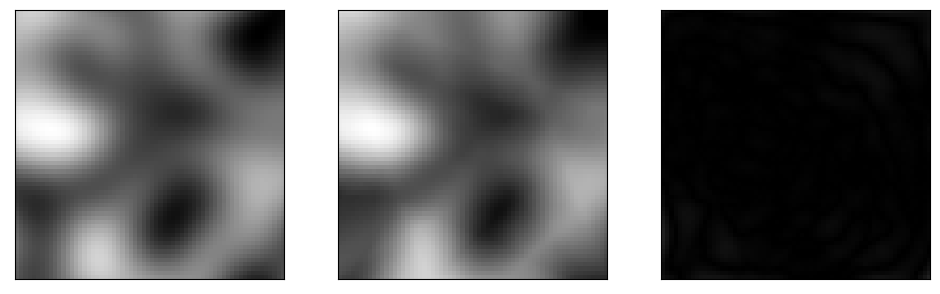

In [10]:
img_pred = perceptron2(X.to(device))[:,0].detach().cpu().reshape(n_y,n_x)
diff = tch.abs(img_pred-img.to(tch.float32))
list_img = [img, img_pred, diff]
fig, ax = disp(list_img,(1,3),2);

for i in range(3):
    im = ax[0,i].get_images()[0]
    im.set_clim(0.,255)

In [26]:
data_train = np.genfromtxt('img/mnist_train_small.csv',delimiter=',')
data_train_2 = np.genfromtxt('img/mnist_train_small_2.csv',delimiter=',')
data_train = np.concatenate((data_train, data_train_2), axis=0)

(20000, 785)

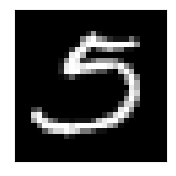

In [12]:
Y = np.uint8(data_train[:,0])
X = np.float32(data_train[:,1:])
n_x, n_y = 28, 28
disp(X[5000].reshape(n_y,n_x));

### Création d'une classe Dataset appelé Mnist 
Elle sert à collecter les données dans un data_loader. On gardera les images sous forme de vecteurs.

In [13]:
class Mnist(Dataset):
    def __init__(self, X, Y, data_size):
        self.len = data_size
        self.X = X
        self.Y = Y
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

### Création d'une instance de DataLoader 
Elle permet de charger et d'itérer sur le dataset Mnist.

In [14]:
data_loader = tch.utils.data.DataLoader(Mnist(X,Y,X.shape[0]),
                                        batch_size=1000,
                                        shuffle=True)

### Création d'un réseau de neurones 
Il comporte 3 couches linéaires intercallées avec 2 couches d'activation ReLU et la fonction de coût est CrossEntropyLoss, de formule générale :
$$
L(y, \hat{y}) = - (y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}))
$$
Les dimensions des couches sont données ci-dessous.

In [15]:
D_0 = n_x*n_y
D_1 = 2*D_0
D_2 = D_0//2
D_3 = 10
neural_net = tch.nn.Sequential(tch.nn.Linear(D_0,D_1), tch.nn.ReLU(),
                               tch.nn.Linear(D_1,D_2), tch.nn.ReLU(),
                               tch.nn.Linear(D_2,D_3)).to(device)
loss_func = tch.nn.CrossEntropyLoss(reduction='sum')

### Création de l'optimizer AdamW, du scheduler et entraînement du réseau
Le weight_decay sera fixé à 0.1, le learning rate à 1e-3. Pour le scheduler, on divisera par 10 
le learning rate aprés 250 epoch.

In [16]:
optimizer = tch.optim.AdamW(neural_net.parameters(), lr=1e-3,
                            weight_decay=0.1)
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=250,
                                          gamma=0.1)

In [17]:
if device == 'cuda' :
    running_loss = 0.0
    epoch_loss = 0.0
    epoch_loss_ = 0.0
    n_epoch = 500

    for epoch in range(n_epoch):
        i = 0
        for data in data_loader:
            ###### COMPLETER ICI ######
            x, y = data[0].to(device), data[1].to(device)
            y_pred = neural_net(x)
            loss_val = loss_func(y_pred,y)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            ######

            running_loss += loss_val.item()
            epoch_loss_ += loss_val.item()
            i += 1
            if i % 10 == 0:    # every 5 mini-batches...
                disp_2losses(running_loss, epoch_loss, epoch)
                running_loss = 0
        epoch_loss = 1.0*epoch_loss_
        epoch_loss_ = 0.0

In [18]:
## si on veut sauvegarder le modèle
# tch.save(neural_net.state_dict(),'img/neural_net.pt')

On va charger le modèle entraîné depuis une machine plus puissante.

In [19]:
# charger les poids du réseau entrainé si vous ne pouvez pas l'entrainer 
# sur votre ordi
loaded_weights = tch.load('img/neural_net.pt', map_location=tch.device('cpu'))
neural_net.load_state_dict(loaded_weights)

<All keys matched successfully>

In [20]:
# on évalue les performances sur l'ensemble d'apprentissage
correct = tch.zeros(len(data_loader))
i = 0
for data in data_loader:
    x, y = data[0].to(device), data[1].to(device)
    y_pred = tch.softmax(neural_net(x), 1).argmax(1) 
    # attention ci-dessus pour obtenir les proba il faut calculer le softmax 
    # de la sortie du réseau de neurones
    correct[i] = tch.mean((y_pred==y).to(tch.float32))
    i+=1

In [21]:
print('percent correct: %.2f'%(100*correct.mean()))
# les prédictions sont parfaites ... peut-être que le réseau s'est 
# sur-ajusté sur les données d'entrainement.

percent correct: 100.00


### On évalue les performances sur l'ensemble de test.

In [22]:
data_test = np.genfromtxt('img/mnist_test.csv',delimiter=',')
Y_test = tch.from_numpy(np.uint8(data_test[:,0])).to(device)
X_test = tch.from_numpy(np.float32(data_test[:,1:])).to(device)

In [23]:
# on évalue les performances sur l'ensemble de test
y_test_pred = tch.softmax(neural_net(X_test), 1).argmax(1)
correct_test = tch.mean((y_test_pred==Y_test).to(tch.float32))

print('percent correct: %.2f'%(100*correct_test))

percent correct: 96.63


In [28]:
print('Le pourcentage des données de test est : %.2f %% pour un total de données : %d' % ((data_test.shape[0] * 100) / (data_train.shape[0] + data_test.shape[0]), (data_train.shape[0] + data_test.shape[0])) + ". Donc, avec ce pourcentage d'erreur, le modèle semble donc être performant.")

Le pourcentage des données de test est : 33.33 % pour un total de données : 30000. Donc avec ce pourcentage d'erreur, le modèle semble donc être performant.
